In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.losses import Huber

# open HDF5 file
files = ["Project_B_Data_Phase1/cushion_hyperelastic100x100x50.h5",
         "Project_B_Data_Phase1/cushion_hyperelastic120x100x25.h5",
         "Project_B_Data_Phase1/cushion_hyperelastic120x100x50.h5",
         "Project_B_Data_Phase1/cushion_hyperelastic120x100x100.h5",
         "Project_B_Data_Phase1/cushion_hyperelastic120x120x50.h5",
         "Project_B_Data_Phase1/cushion_hyperelastic200x200x50.h5",
         "Project_B_Data_Phase1/cushion_hyperelastic220x200x75.h5",]

#Initialize storage list
data_list = []

#读取数据
for filepath in files:
    data = h5py.File(filepath, 'r')
    data_list.append(data)

In [2]:
with h5py.File(files[0], "r") as h5_file:
    def print_shapes(name, obj):
        # 检查对象类型，如果是数据集则打印形状
        if isinstance(obj, h5py.Dataset):
            print(f"Path: {name}, Shape: {obj.shape}")

    # 递归遍历文件中的所有路径
    h5_file.visititems(print_shapes)

Path: Function/CS/0, Shape: (1183, 9)
Path: Function/CS/1, Shape: (1183, 9)
Path: Function/CS/10, Shape: (1183, 9)
Path: Function/CS/11, Shape: (1183, 9)
Path: Function/CS/12, Shape: (1183, 9)
Path: Function/CS/13, Shape: (1183, 9)
Path: Function/CS/14, Shape: (1183, 9)
Path: Function/CS/15, Shape: (1183, 9)
Path: Function/CS/16, Shape: (1183, 9)
Path: Function/CS/17, Shape: (1183, 9)
Path: Function/CS/18, Shape: (1183, 9)
Path: Function/CS/19, Shape: (1183, 9)
Path: Function/CS/2, Shape: (1183, 9)
Path: Function/CS/20, Shape: (1183, 9)
Path: Function/CS/3, Shape: (1183, 9)
Path: Function/CS/4, Shape: (1183, 9)
Path: Function/CS/5, Shape: (1183, 9)
Path: Function/CS/6, Shape: (1183, 9)
Path: Function/CS/7, Shape: (1183, 9)
Path: Function/CS/8, Shape: (1183, 9)
Path: Function/CS/9, Shape: (1183, 9)
Path: Function/FS/0, Shape: (1183, 9)
Path: Function/FS/1, Shape: (1183, 9)
Path: Function/FS/10, Shape: (1183, 9)
Path: Function/FS/11, Shape: (1183, 9)
Path: Function/FS/12, Shape: (1183, 9

In [3]:
import re  # 用于从文件名中提取数字

# Function to extract three numbers from the filename
def extract_numbers(filename):
    # 假设文件名包含三个数字，用正则表达式提取
    match = re.findall(r'(\d+)', filename)
    if len(match) >= 3:
        return [int(match[0]), int(match[1]), int(match[2])]
    else:
        raise ValueError(f"Filename {filename} does not contain enough numbers!")

results = []
uS_results = []  # 用于存储 "Function/uS/{i}" 数据的列表
group_results_x = []  # 用于储存每个文件的 input matrix
group_results_y = []  # 用于储存每个文件的 output matrix
template_paths = [
    "Function/CS/{i}", "Function/FS/{i}", "Function/KF/{i}",
    "Function/P_S/{i}", "Function/S_S/{i}", "Function/T_S/{i}",
    "Function/eigS1_CS/{i}", "Function/eigS2_CS/{i}", "Function/eigS3_CS/{i}",
    "Function/gradp/{i}", "Function/p/{i}", "Function/uS/{i}",
    "Function/vF/{i}", "Function/wFR/{i}", "Mesh/mesh/geometry",
]
t_base = np.ones(1183).reshape(1183, 1)

# 遍历 data_list 中的每个元素
for idx, f in enumerate(data_list):
    results.clear()
    uS_results.clear()  # 每次处理一个 f 时清空 uS_results

    # 从文件名提取三个数字
    filename = files[idx]
    extra_features = extract_numbers(filename)
    extra_features_array = np.array(extra_features).reshape(1, -1)  # (1, 3)

    for i in range(21):
        feature_i = []
        for path in template_paths:
            formatted_path = path.format(i=i)
            try:
                # 尝试获取数据
                if "Function/uS/{i}" in path:
                    uS_results.append(f[formatted_path])  # 单独存储 "Function/uS/{i}" 数据
                else:
                    feature_i.append(f[formatted_path])
            except KeyError:
                # 如果路径不存在，则跳过当前 i 的循环
                print(f"Path {formatted_path} does not exist. Skipping i={i}.")
                break  # 退出当前 i 循环
        else:
            # 只有当没有遇到错误时，才继续处理这个 i
            feature_i.append(i * t_base)
            results.append(np.hstack(feature_i))
    
    # 将所有结果按行堆叠
    group_result_x = np.vstack(results)
    
    # 将提取的三个数字广播并添加到 input matrix
    extra_features_broadcast = np.tile(extra_features_array, (group_result_x.shape[0], 1))  # 将 (1, 3) 扩展为 (n_rows, 3)
    group_result_x_with_features = np.hstack([group_result_x, extra_features_broadcast])  # 添加到右边
    group_results_x.append(group_result_x_with_features)
    print(f"Inp_matrix shape with extra features: {group_result_x_with_features.shape}")

    # 将 "Function/uS/{i}" 数据竖向堆叠成一个矩阵
    if uS_results:
        uS_matrix = np.vstack(uS_results)
        group_results_y.append(uS_matrix)
        print(f"Dis_matrix shape: {uS_matrix.shape}")

# 堆叠最终的 x 和 y
dataset_x = np.vstack(group_results_x)
print(f"final input matrix shape with extra features: {dataset_x.shape}")
y = np.vstack(group_results_y)
print(f"final output matrix shape: {y.shape}")


Inp_matrix shape with extra features: (24843, 66)
Dis_matrix shape: (24843, 3)
Path Function/CS/12 does not exist. Skipping i=12.
Path Function/CS/13 does not exist. Skipping i=13.
Path Function/CS/14 does not exist. Skipping i=14.
Path Function/CS/15 does not exist. Skipping i=15.
Path Function/CS/16 does not exist. Skipping i=16.
Path Function/CS/17 does not exist. Skipping i=17.
Path Function/CS/18 does not exist. Skipping i=18.
Path Function/CS/19 does not exist. Skipping i=19.
Path Function/CS/20 does not exist. Skipping i=20.
Inp_matrix shape with extra features: (14196, 66)
Dis_matrix shape: (14196, 3)
Inp_matrix shape with extra features: (24843, 66)
Dis_matrix shape: (24843, 3)
Inp_matrix shape with extra features: (24843, 66)
Dis_matrix shape: (24843, 3)
Inp_matrix shape with extra features: (24843, 66)
Dis_matrix shape: (24843, 3)
Inp_matrix shape with extra features: (24843, 66)
Dis_matrix shape: (24843, 3)
Inp_matrix shape with extra features: (24843, 66)
Dis_matrix shape:

In [4]:
scalerx = MinMaxScaler()
#Normalize the dataset dataset and store it in x
x = scalerx.fit_transform(dataset_x)

In [5]:
#divide our test array
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=27)

In [6]:
# initialize a object named model from Tensorflow Sequential model class.
model = Sequential()

# 使用 Input 层明确声明输入形状
model.add(Input(shape=(x_train.shape[1],)))  # 显式声明输入层

# 后续层直接添加
model.add(Dense(50, activation='relu'))  # 隐藏层1
model.add(Dense(30, activation='relu'))  # 隐藏层2
model.add(Dense(10, activation='relu'))  # 隐藏层3

model.add(Dense(3))  # 输出层

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           3,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,223 (20.40 KB)

 Trainable params: 5,223 (20.40 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the built model with optimizer, loss and metrics

adam = tf.keras.optimizers.Adam(learning_rate=1e-8)
#adam = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)... for mac users
model.compile(optimizer='adam', loss='mae', metrics=['mse','mae'])

In [9]:
history = model.fit(x_train,y_train,epochs=16,batch_size=64,validation_data=(x_test,y_test))

Epoch 1/16
1786/1786 ━━━━━━━━━━━━━━━━━━━━ 3s 872us/step - loss: 2.8134 - mae: 2.8134 - mse: 41.8476 - val_loss: 2.6530 - val_mae: 2.6530 - val_mse: 34.3525
Epoch 2/16
1786/1786 ━━━━━━━━━━━━━━━━━━━━ 2s 830us/step - loss: 2.6597 - mae: 2.6597 - mse: 34.5909 - val_loss: 2.6541 - val_mae: 2.6541 - val_mse: 34.8399
Epoch 3/16
1786/1786 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.6501 - mae: 2.6501 - mse: 34.2354 - val_loss: 2.6530 - val_mae: 2.6530 - val_mse: 34.1994
Epoch 4/16
1786/1786 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.6605 - mae: 2.6605 - mse: 34.4445 - val_loss: 2.6529 - val_mae: 2.6529 - val_mse: 34.1019
Epoch 5/16
1786/1786 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.6537 - mae: 2.6537 - mse: 34.4026 - val_loss: 2.6543 - val_mae: 2.6543 - val_mse: 34.9660
Epoch 6/16
1786/1786 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.6598 - mae: 2.6598 - mse: 34.5537 - val_loss: 2.6531 - val_mae: 2.6531 - val_mse: 34.3200
Epoch 7/16
1786/1786 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - loss: 2.6616 -

In [10]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,2.720397,2.720397,37.579449,2.652972,2.652972,34.352493
1,2.656599,2.656599,34.444893,2.654081,2.654081,34.839893
2,2.656573,2.656573,34.419212,2.653009,2.653009,34.199421
3,2.656469,2.656469,34.461681,2.652864,2.652864,34.101910
4,2.656576,2.656576,34.409218,2.654265,2.654265,34.965973


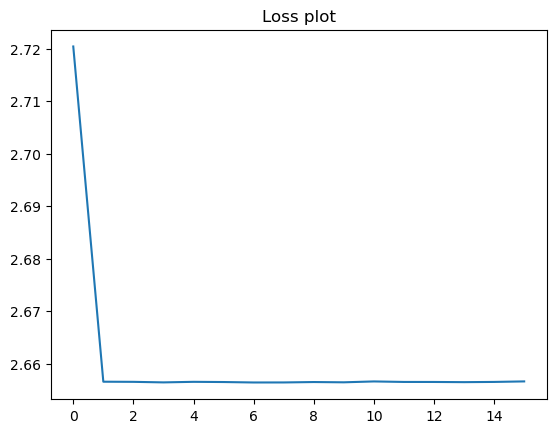

In [11]:
plt.title('Loss plot')
plt.plot(hist['loss'])

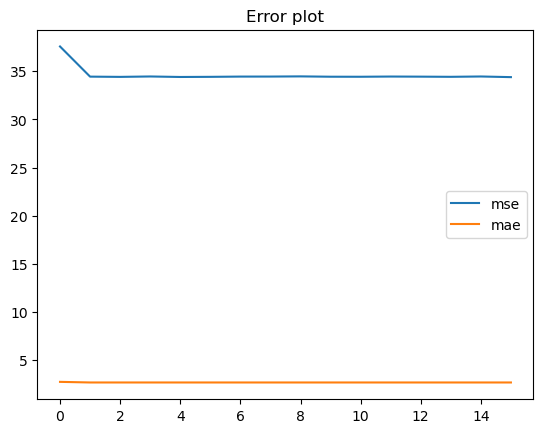

In [12]:
plt.title('Error plot')
plt.plot(hist['mse'], label='mse')
plt.plot(hist['mae'], label='mae')
plt.legend()